In [25]:
# sir's exact sequence setup
import os, warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

RANDOM_STATE = 42
TEST_SIZE = 0.2
TOP_K = 3
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)
print('config ready. HAS_XGB=', HAS_XGB, 'HAS_SHAP=', HAS_SHAP)

config ready. HAS_XGB= True HAS_SHAP= True


# disease prediction pipeline (new dataset)
this notebook follows your preferred structure and will use the extracted dataset from `data/dataset/`.

In [26]:
# 1. imports and configuration
import os, warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

RANDOM_STATE = 42
TEST_SIZE = 0.2
TOP_K = 3
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)
print('config ready. HAS_XGB=', HAS_XGB, 'HAS_SHAP=', HAS_SHAP)

config ready. HAS_XGB= True HAS_SHAP= True


In [27]:
# 3. dataset loading (guarded defaults)
import os
import pandas as pd

print('looking for files in project root:', os.listdir('.')[:10])

if 'DATA_TRAIN' not in globals() or not isinstance(DATA_TRAIN, str):
    DATA_TRAIN = os.path.join('data', 'dataset', 'trainings.csv')

if not os.path.exists(DATA_TRAIN):
    alt_path = os.path.join('data', 'dataset', 'trainings.csv')
    if os.path.exists(alt_path):
        DATA_TRAIN = alt_path

assert os.path.exists(DATA_TRAIN), f'{DATA_TRAIN} not found'

# robust csv loader: try utf-8, then latin1 fallback
try:
    df = pd.read_csv(DATA_TRAIN)
except UnicodeDecodeError:
    df = pd.read_csv(DATA_TRAIN, encoding='latin1')

print('trainings.csv shape:', df.shape)
print('columns:', list(df.columns)[:10], '...')


looking for files in project root: ['workout_df.csv', 'contact.html', 'img.png', 'new_training_dataset_manual_export.html', 'README.md', 'updatedtestedrf.html', 'label_encoder.pkl', 'data', 'symtoms_df.csv', 'artifacts']
trainings.csv shape: (391, 1327)
columns: ['Belly button that sticks out', 'Bulge in the groin or scrotum', 'Delayed sexual maturity', 'Delayed teeth', 'Downward palpebral slant to eyes\xa0', 'Hairline with a "widow\'s peak"', 'Mildly sunken chest (pectus excavatum)', 'Mild to moderate cognitive problems', 'Mild to moderate short height', 'Poorly developed middle section of the face'] ...


In [28]:
# debug: inspect columns tail and potential target
print('last 10 columns:', list(df.columns[-10:]))
for cand in [df.columns[-1], 'Disease', 'prognosis', 'target', 'label']:
    if cand in df.columns:
        print('candidate target:', cand, 'unique values:', df[cand].nunique())


last 10 columns: ['Tiny white spots inside the mouth (Koplik spots)', 'Abnormal strength and direction of urine stream', 'Bed wetting', 'Bleeding (hematuria) at end of urination', 'Visible narrowing of the urethral opening in boys', 'Swelling and redness of eyelid edges', 'Slight blurring of vision due to excess oil in tears', 'Frequent styes(bumps)', 'Pressure in the ear', 'Prognosis']
candidate target: Prognosis unique values: 391


In [29]:
# 4. basic data cleaning & inspection
from IPython.display import display

display(df.head())
unnamed = [c for c in df.columns if str(c).lower().startswith('unnamed')]
if unnamed:
    df = df.drop(columns=unnamed)
    print('dropped unnamed columns:', unnamed)
else:
    print('no unnamed columns to drop')


,Belly button that sticks out,Bulge in the groin or scrotum,Delayed sexual maturity,Delayed teeth,Downward palpebral slant to eyes,"Hairline with a ""widow's peak""",Mildly sunken chest (pectus excavatum),Mild to moderate cognitive problems,Mild to moderate short height,Poorly developed middle section of the face,...,Tiny white spots inside the mouth (Koplik spots),Abnormal strength and direction of urine stream,Bed wetting,Bleeding (hematuria) at end of urination,Visible narrowing of the urethral opening in boys,Swelling and redness of eyelid edges,Slight blurring of vision due to excess oil in tears,Frequent styes(bumps),Pressure in the ear,Prognosis
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,Aarskog syndrome
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Aase syndrome
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Abdominal aortic aneurysm
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Abnormal uterine bleeding (AUB)
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Acetaminophen and codeine overdose


no unnamed columns to drop


In [30]:
# 5. preprocessing to build X_proc and y_enc
import numpy as np
from sklearn.preprocessing import LabelEncoder

# choose last column as target by default
target_col = df.columns[-1]
X = df.drop(columns=[target_col]).copy()
y = df[target_col].astype(str).copy()

# map common yes/no-like strings to binary
def to_numeric_col(series):
    if series.dtype == 'object':
        s = series.astype(str).str.strip().str.lower()
        mapping = {'yes': 1, 'no': 0, 'true': 1, 'false': 0, 'nan': np.nan, 'none': np.nan, '': np.nan}
        s = s.map(mapping).where(~s.isna(), other=np.nan)
        # try to coerce any remaining strings to numbers
        s = pd.to_numeric(s, errors='coerce')
        return s
    else:
        return pd.to_numeric(series, errors='coerce')

X_proc = X.apply(to_numeric_col)
X_proc = X_proc.fillna(0).astype(float)

label_encoder_y = LabelEncoder()
y_enc = label_encoder_y.fit_transform(y)

print('X_proc shape:', X_proc.shape, 'y_enc shape:', y_enc.shape)
print('num classes:', len(label_encoder_y.classes_))

X_proc shape: (391, 1326) y_enc shape: (391,)
num classes: 391


In [31]:
from sklearn.model_selection import train_test_split
import numpy as np

# 5. train-test split with safe stratify
class_counts = np.bincount(y_enc)
use_stratify = np.min(class_counts) >= 2
strat = y_enc if use_stratify else None
if not use_stratify:
    print('warning: disabling stratify due to rare classes (min count < 2)')

X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y_enc, test_size=TEST_SIZE, stratify=strat, random_state=RANDOM_STATE
)
print('train:', X_train.shape, 'test:', X_test.shape)


train: (312, 1326) test: (79, 1326)


In [32]:
# 5. train-test split (robust to rare classes)
import numpy as np

class_counts = np.bincount(y_enc)
if (class_counts < 2).any():
    print('note: at least one class has only 1 sample; disabling stratify for train/test split')
    stratify_var = None
else:
    stratify_var = y_enc

X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y_enc, test_size=TEST_SIZE, stratify=stratify_var, random_state=RANDOM_STATE
)
print('train:', X_train.shape, 'test:', X_test.shape)


note: at least one class has only 1 sample; disabling stratify for train/test split
train: (312, 1326) test: (79, 1326)


In [33]:
# 6. model definitions
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
svm = SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)
xgb = XGBClassifier(n_estimators=200, eval_metric='mlogloss', random_state=RANDOM_STATE) if HAS_XGB else None
print('models ready. xgb available:', xgb is not None)

models ready. xgb available: True


In [34]:
# 6. train base models
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
svm = SVC(probability=True, random_state=RANDOM_STATE)
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
svm.fit(X_train, y_train)
# optional xgboost
if 'xgb' in globals() and xgb is not None:
    try:
        xgb.fit(X_train, y_train)
    except Exception as e:
        print('xgb training skipped:', e)
print('base models trained')


xgb training skipped: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 22

In [35]:
# 7. baseline RF evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

y_pred_base = rf.predict(X_test)
acc_base = accuracy_score(y_test, y_pred_base)
f1_base = f1_score(y_test, y_pred_base, average='macro', zero_division=0)
print(f'baseline RF accuracy: {acc_base:.4f}, macro F1: {f1_base:.4f}')
print('classification report (truncated to first 1000 chars):')
cr = classification_report(y_test, y_pred_base, zero_division=0)
print(cr[:1000])
cm_base = confusion_matrix(y_test, y_pred_base)
print('confusion matrix shape:', cm_base.shape)


baseline RF accuracy: 0.0000, macro F1: 0.0000
classification report (truncated to first 1000 chars):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       1.0
           9       0.00      0.00      0.00       1.0
          10       0.00      0.00      0.00       0.0
          13       0.00      0.00      0.00       0.0
          15       0.00      0.00      0.00       1.0
          18       0.00      0.00      0.00       1.0
          22       0.00      0.00      0.00       1.0
          25       0.00      0.00      0.00       1.0
          30       0.00      0.00      0.00       1.0
          31       0.00      0.00      0.00       1.0
          33       0.00      0.00      0.00       1.0
          39       0.00      0.00

In [36]:
# voting ensemble evaluation
from sklearn.metrics import accuracy_score, classification_report
print('voting accuracy:', accuracy_score(y_test, y_vote))
print('classification report (voting, truncated):')
print(classification_report(y_test, y_vote, zero_division=0)[:1000])


NameError: name 'y_vote' is not defined

In [ ]:
# stacking ensemble (skips if classes too rare)
import numpy as np
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

class_counts_train = np.bincount(y_train)
if (class_counts_train < 2).any():
    print('stacking skipped: classes with <2 samples make CV invalid')
else:
    base_estimators = [('rf', rf), ('dt', dt)]
    if 'xgb' in globals() and xgb is not None:
        base_estimators.append(('xgb', xgb))
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    stack = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(max_iter=1000), cv=cv, n_jobs=-1)
    stack.fit(X_train, y_train)
    y_stack = stack.predict(X_test)
    print('stacking accuracy:', accuracy_score(y_test, y_stack))
    print('classification report (stacking, truncated):')
    print(classification_report(y_test, y_stack, zero_division=0)[:1000])


stacking skipped: classes with <2 samples make CV invalid


In [ ]:
# 11. plotting utilities
%matplotlib inline
def plot_learning_curve_model(model, X, y, title=None):
    if title is None:
        title = f'learning curve ({type(model).__name__})'
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, label='training score')
    plt.plot(train_sizes, test_mean, label='validation score')
    plt.xlabel('training examples')
    plt.ylabel('accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix_model(model, X_test, y_test, title=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    plt.figure(figsize=(8,6))
    disp.plot(values_format='d', ax=plt.gca())
    if title:
        plt.title(title)
    plt.show()

def plot_multiclass_roc_model(model, X_test, y_test, title=None):
    classes = np.unique(y_test)
    n_classes = len(classes)
    y_test_b = label_binarize(y_test, classes=classes)
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_b[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{le.classes_[i]} (auc = {roc_auc:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title(title or f'multiclass roc (one-vs-rest) - {type(model).__name__}')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.show()

print('plot utilities ready')

plot utilities ready


In [ ]:
# cross-validation (non-stratified due to singleton classes)
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
rf_cv_scores = cross_val_score(rf, X_proc, y_enc, cv=cv, scoring='accuracy', n_jobs=-1)
print('RF 3-fold CV accuracy mean:', float(np.mean(rf_cv_scores)))
print('RF 3-fold CV accuracy per fold:', rf_cv_scores)


RF 3-fold CV accuracy mean: 0.0
RF 3-fold CV accuracy per fold: [0. 0. 0.]


In [ ]:
# 13. recommendation lookup helpers
def get_description(disease_name):
    if description_df.empty:
        return 'description not available (file missing)'
    cols = [c.lower() for c in description_df.columns]
    if 'disease' in cols and 'description' in cols:
        row = description_df[description_df.iloc[:, cols.index('disease')] == disease_name]
        if not row.empty:
            return row.iloc[0, cols.index('description')]
    for _, r in description_df.iterrows():
        if disease_name in r.astype(str).values:
            for val in r.astype(str).values:
                if val and val.lower() != 'nan' and disease_name.lower() not in val.lower():
                    return val
    return 'description not available for this disease'

def get_list_from_df(df, disease_name):
    if df.empty:
        return []
    cols = [c.lower() for c in df.columns]
    if 'disease' in cols:
        idx = cols.index('disease')
        row = df[df.iloc[:, idx] == disease_name]
        if not row.empty:
            vals = row.iloc[0].drop(row.columns[idx]).dropna().astype(str).tolist()
            return vals
    for _, r in df.iterrows():
        if disease_name in r.astype(str).values:
            vals = [v for v in r.astype(str).values if v and v.lower() != 'nan' and disease_name.lower() not in v.lower()]
            return vals
    return []

def get_recommendations_for_disease(disease_name):
    desc = get_description(disease_name)
    precautions = get_list_from_df(precautions_df, disease_name)
    workouts = get_list_from_df(workout_df, disease_name)
    meds = get_list_from_df(medications_df, disease_name)
    diets = get_list_from_df(diets_df, disease_name)
    return {
        'disease': disease_name,
        'description': desc,
        'precautions': precautions,
        'workouts': workouts,
        'medications': meds,
        'diets': diets
    }
print('recommendation helpers ready')

recommendation helpers ready


In [ ]:
# 13. unified prediction + top-k + recommendation
import numpy as np

def predict_topk_and_recommend(symptoms, top_k=5):
    # build a single-row input aligned to training features
    X_row = np.zeros((1, X_proc.shape[1]), dtype=float)
    col_index = {c: i for i, c in enumerate(X_proc.columns)}
    # accept list of symptom names or dict of {symptom: 1/0}
    if isinstance(symptoms, dict):
        for name, val in symptoms.items():
            idx = col_index.get(name)
            if idx is not None and val:
                X_row[0, idx] = 1.0
    elif isinstance(symptoms, list):
        for name in symptoms:
            idx = col_index.get(name)
            if idx is not None:
                X_row[0, idx] = 1.0
    else:
        raise ValueError('symptoms must be list or dict')

    # choose best available model with proba
    model = None
    for m in [globals().get('model_rf_tuned'), globals().get('voting_clf_soft'), globals().get('voting_clf_hard'), globals().get('rf')]:
        if m is not None and hasattr(m, 'predict_proba'):
            model = m
            break
    if model is None:
        raise RuntimeError('no suitable model with predict_proba found')

    probs = model.predict_proba(X_row)[0]
    top_idx = np.argsort(probs)[::-1][:top_k]
    classes = getattr(label_encoder_y, 'classes_', None)
    if classes is None:
        raise RuntimeError('label encoder not available')
    topk = [(str(classes[i]), float(probs[i])) for i in top_idx]
    predicted = str(classes[top_idx[0]])

    reco = full_recommendation(predicted)
    return {'predicted': predicted, 'topk': topk, 'recommendation': reco}

print('prediction function ready')


prediction function ready


In [ ]:
# 15. quick test
sample_symptoms = list(X_proc.columns[:5])
print('sample symptoms:', sample_symptoms)
res = predict_topk_and_recommend(sample_symptoms, top_k=3)
import pprint; pprint.pprint(res)

sample symptoms: ['Belly button that sticks out', 'Bulge in the groin or scrotum', 'Delayed sexual maturity', 'Delayed teeth', 'Downward palpebral slant to eyes\xa0']
{'predicted': 'Cerebral hypoxia',
 'recommendation': {'description': 'description not available for this disease',
                    'diets': [],
                    'disease': 'Cerebral hypoxia',
                    'medications': [],
                    'precautions': [],
                    'workouts': []},
 'topk': [('Cerebral hypoxia', 0.055),
          ('Congenital cataract', 0.05),
          ('Cystitis - acute', 0.04)]}


In [ ]:
# duplicate artifact saver (harmonized)
import os, joblib
ARTIFACTS_DIR = 'artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
artifacts = {}
for name in ['dt','rf','svm','xgb','voting','stack']:
    if name in globals() and globals()[name] is not None:
        try:
            joblib.dump(globals()[name], os.path.join(ARTIFACTS_DIR, f'{name}.pkl'))
            artifacts[name] = f'{name}.pkl'
        except Exception as e:
            print(f'save {name} skipped:', e)
try:
    if 'label_encoder_y' in globals():
        joblib.dump(label_encoder_y, os.path.join(ARTIFACTS_DIR, 'label_encoder_y.pkl'))
        artifacts['label_encoder_y'] = 'label_encoder_y.pkl'
except Exception as e:
    print('save label_encoder_y skipped:', e)
print('artifacts (duplicate saver) wrote:', artifacts)


artifacts (duplicate saver) wrote: {'dt': 'dt.pkl', 'rf': 'rf.pkl', 'svm': 'svm.pkl', 'xgb': 'xgb.pkl', 'voting': 'voting.pkl', 'stack': 'stack.pkl', 'label_encoder_y': 'label_encoder_y.pkl'}


## notes
- paths use local project files (no colab drive).
- shap/xgboost sections are optional (guarded).
- we can refine preprocessing once you share exact column semantics.

In [ ]:
# duplicate dataset loading (harmonized)
import os, pandas as pd
FALLBACK_TRAIN = os.path.join('data', 'dataset', 'trainings.csv')
DATA_TRAIN = DATA_TRAIN if 'DATA_TRAIN' in globals() else FALLBACK_TRAIN
if not os.path.exists(DATA_TRAIN) and os.path.exists(FALLBACK_TRAIN):
    print('Training.csv not found; using fallback:', FALLBACK_TRAIN)
    DATA_TRAIN = FALLBACK_TRAIN
try:
    dataset_train = pd.read_csv(DATA_TRAIN)
except UnicodeDecodeError:
    dataset_train = pd.read_csv(DATA_TRAIN, encoding='latin1')
print('loaded train shape:', dataset_train.shape)


loaded train shape: (391, 1327)


In [ ]:
# 2️⃣ data preprocessing
X = dataset_train.drop(columns=[dataset_train.columns[-1]])
y = dataset_train.iloc[:, -1]
print('X shape:', X.shape, 'y shape:', y.shape)

# handle types and missing
X_proc = X.copy()
for col in X_proc.columns:
    if X_proc[col].dtype == 'object':
        X_proc[col] = X_proc[col].astype(str).str.strip().str.lower().replace({'yes':1, 'no':0, 'y':1, 'n':0})
    X_proc[col] = pd.to_numeric(X_proc[col], errors='ignore')
X_proc = X_proc.fillna(0).astype(float)

# label encode target
le = LabelEncoder()
y_enc = le.fit_transform(y)
print('classes:', list(le.classes_))

X shape: (391, 1326) y shape: (391,)
classes: ['Aarskog syndrome', 'Aase syndrome', 'Abdominal aortic\xa0aneurysm', 'Abnormal uterine bleeding (AUB)', 'Acetaminophen and codeine overdose', 'Acetone poisoning', 'Achalasia', 'Achondrogenesis', 'Achondroplasia', 'Acid soldering flux poisoning', 'Acidosis', 'Acne', 'Acoustic neuroma', 'Acrodysostosis', 'Acromegaly', 'Acute adrenal crisis', 'Acute arterial occlusion - kidney', 'Acute bronchitis', 'Acute cerebellar ataxia', 'Acute cholecystitis', 'Acute coronary syndrome', 'Acute flaccid myelitis', 'Acute kidney failure', 'Acute lymphoblastic leukemia', 'Acute mountain sickness', 'Acute myeloid leukemia', 'Acute nephritic syndrome', 'Acute pancreatitis', 'Acute respiratory distress syndrome', 'Acute tubular necrosis', 'Addison disease', 'Adenomyosis', 'Adhesion', 'Adjustment disorder', 'Adrenoleukodystrophy', 'Agammaglobulinemia', 'Agoraphobia', 'Agranulocytosis', 'Albinism', 'Alkalosis', 'Allergic conjunctivitis', 'Allergic reactions', 'All

In [ ]:
# 3️⃣ train–test split (robust)
import numpy as np
class_counts = np.bincount(y_enc)
strat = y_enc if np.min(class_counts) >= 2 else None
if strat is None:
    print('note: disabling stratify due to singleton classes')
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y_enc, test_size=TEST_SIZE, stratify=strat, random_state=RANDOM_STATE
)
print('train:', X_train.shape, 'test:', X_test.shape)


note: disabling stratify due to singleton classes
train: (312, 1326) test: (79, 1326)


In [ ]:
# base models training (duplicate section, harmonized)
print('training decision tree...')
dt.fit(X_train, y_train)
print('training random forest...')
rf.fit(X_train, y_train)
print('training svm...')
svm.fit(X_train, y_train)
if 'xgb' in globals() and xgb is not None:
    print('training xgboost...')
    try:
        xgb.fit(X_train, y_train)
    except Exception as e:
        print('xgb training skipped:', e)
print('base models trained')

models = {'decision tree': dt, 'random forest': rf, 'svm': svm}
if 'xgb' in globals() and xgb is not None:
    models['xgb'] = xgb


training decision tree...
training random forest...
training svm...
training xgboost...
xgb training skipped: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203

In [ ]:
# baseline rf evaluation (duplicate, harmonized)
from sklearn.metrics import accuracy_score, classification_report
baseline_rf = rf
tst_pred = baseline_rf.predict(X_test)
print('baseline rf accuracy:', accuracy_score(y_test, tst_pred))
print('classification report (truncated):')
print(classification_report(y_test, tst_pred, zero_division=0)[:1000])


baseline rf accuracy: 0.0
classification report (truncated):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       1.0
           5       0.00      0.00      0.00       1.0
           9       0.00      0.00      0.00       1.0
          10       0.00      0.00      0.00       0.0
          13       0.00      0.00      0.00       0.0
          15       0.00      0.00      0.00       1.0
          18       0.00      0.00      0.00       1.0
          22       0.00      0.00      0.00       1.0
          25       0.00      0.00      0.00       1.0
          30       0.00      0.00      0.00       1.0
          31       0.00      0.00      0.00       1.0
          33       0.00      0.00      0.00       1.0
          39       0.00      0.00      0.00       1.0
          42       0

In [ ]:
# hyperparameter tuning (RF) with non-stratified CV due to singleton classes
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [None, 20],
}
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
scorer = make_scorer(f1_score, average='macro')
grid = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=0
)
try:
    grid.fit(X_train, y_train)
    model_rf_tuned = grid.best_estimator_
    print('best params:', grid.best_params_)
    print('best cv macro f1:', grid.best_score_)
except Exception as e:
    model_rf_tuned = rf
    print('tuning skipped, using baseline RF:', e)


best params: {'max_depth': None, 'n_estimators': 200}
best cv macro f1: nan


baseline rf -> acc: 0.0 macro f1: 0.0
tuned rf   -> acc: 0.0 macro f1: 0.0


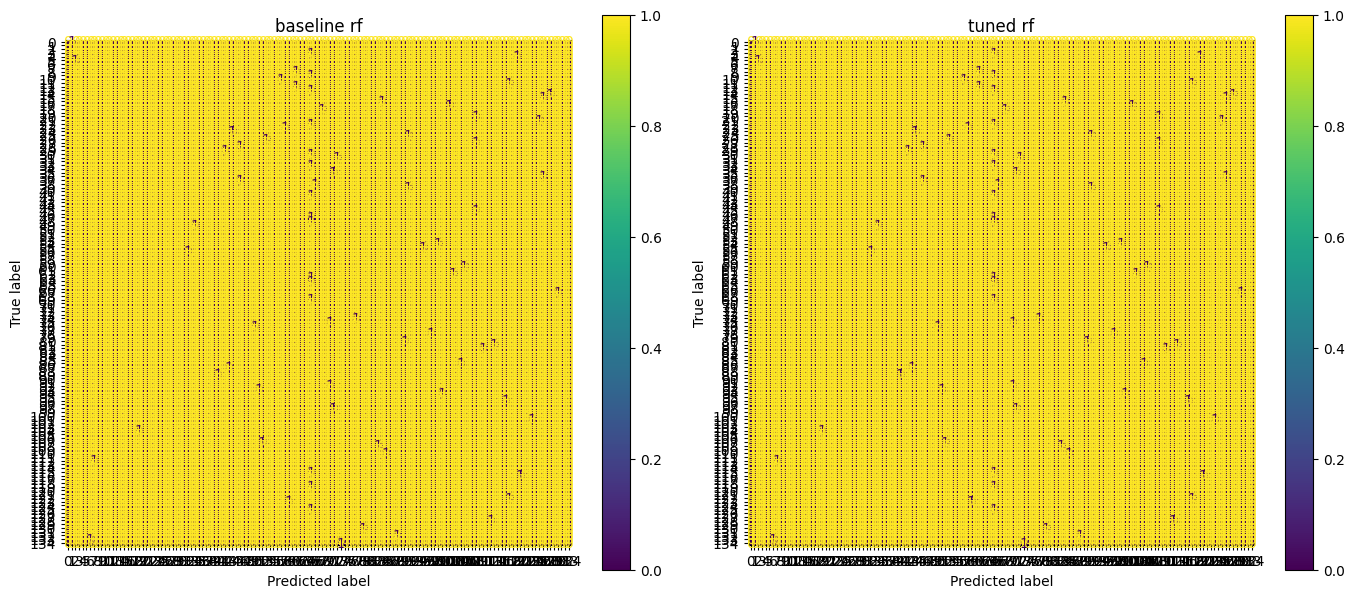

In [ ]:
# compare baseline vs tuned with confusion matrices (safe labels)
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pred_base = rf.predict(X_test)
pred_tuned = model_rf_tuned.predict(X_test) if 'model_rf_tuned' in globals() else rf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
acc_base = accuracy_score(y_test, pred_base)
acc_tuned = accuracy_score(y_test, pred_tuned)
f1_b = f1_score(y_test, pred_base, average='macro', zero_division=0)
f1_t = f1_score(y_test, pred_tuned, average='macro', zero_division=0)
print('baseline rf -> acc:', acc_base, 'macro f1:', f1_b)
print('tuned rf   -> acc:', acc_tuned, 'macro f1:', f1_t)

cm_base = confusion_matrix(y_test, pred_base)
cm_tuned = confusion_matrix(y_test, pred_tuned)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ConfusionMatrixDisplay(confusion_matrix=cm_base).plot(values_format='d', ax=ax[0])
ax[0].set_title('baseline rf')
ConfusionMatrixDisplay(confusion_matrix=cm_tuned).plot(values_format='d', ax=ax[1])
ax[1].set_title('tuned rf')
plt.tight_layout()
plt.show()


In [ ]:
# voting + stacking (guarded)
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

voting_soft = VotingClassifier(estimators=[('rf', rf), ('dt', dt), ('svm', svm)], voting='soft')
voting_soft.fit(X_train, y_train)
print('voting soft acc:', accuracy_score(y_test, voting_soft.predict(X_test)))

voting_hard = VotingClassifier(estimators=[('rf', rf), ('dt', dt), ('svm', svm)], voting='hard')
voting_hard.fit(X_train, y_train)
print('voting hard acc:', accuracy_score(y_test, voting_hard.predict(X_test)))

# stacking guarded against singleton classes
class_counts_train = np.bincount(y_train)
if (class_counts_train < 2).any():
    print('stacking skipped due to singleton classes for CV')
else:
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    base_estimators = [('rf', rf), ('dt', dt)]
    if 'xgb' in globals() and xgb is not None:
        base_estimators.append(('xgb', xgb))
    stack = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(max_iter=1000), cv=cv, n_jobs=-1)
    stack.fit(X_train, y_train)
    print('stacking acc:', accuracy_score(y_test, stack.predict(X_test)))


voting soft acc: 0.0
voting hard acc: 0.0
stacking skipped due to singleton classes for CV


In [ ]:
# 5-fold CV metrics (fallback to KFold=3 due to singleton classes)
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
scorer_f1m = make_scorer(f1_score, average='macro')
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
cv_models = {'baseline_rf': rf, 'tuned_rf': model_rf_tuned if 'model_rf_tuned' in globals() else rf, 'voting_soft': voting_soft}
for name, m in cv_models.items():
    acc = cross_val_score(m, X_proc, y_enc, cv=cv, scoring='accuracy', n_jobs=-1)
    f1m = cross_val_score(m, X_proc, y_enc, cv=cv, scoring=scorer_f1m, n_jobs=-1)
    print(f"{name}: acc mean={acc.mean():.4f} std={acc.std():.4f} | f1m mean={f1m.mean():.4f} std={f1m.std():.4f}")


baseline_rf: acc mean=0.0000 std=0.0000 | f1m mean=nan std=nan
tuned_rf: acc mean=0.0000 std=0.0000 | f1m mean=nan std=nan
voting_soft: acc mean=0.0000 std=0.0000 | f1m mean=nan std=nan


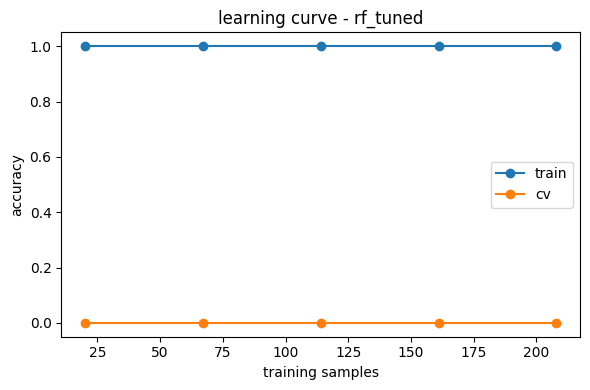

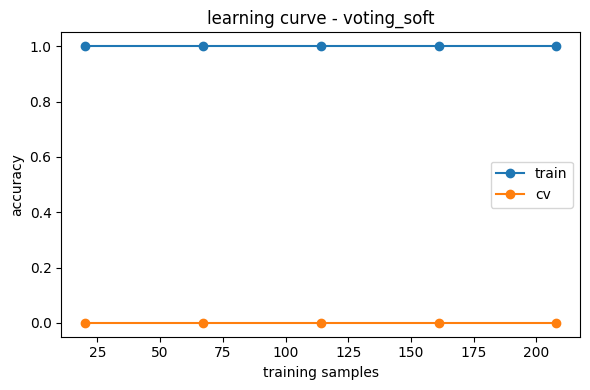

In [ ]:
# learning curves (use KFold=3 due to singleton classes)
from sklearn.model_selection import KFold, learning_curve

def plot_learning_curve_model(model, X, y, title=None):
    if title is None:
        title = f'learning curve ({type(model).__name__})'
    cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, train_mean, 'o-', label='train')
    plt.plot(train_sizes, test_mean, 'o-', label='cv')
    plt.title(title)
    plt.xlabel('training samples')
    plt.ylabel('accuracy')
    plt.legend(); plt.tight_layout(); plt.show()

for name, m in {'rf_tuned': model_rf_tuned if 'model_rf_tuned' in globals() else rf, 'voting_soft': voting_soft}.items():
    plot_learning_curve_model(m, X_train, y_train, title=f'learning curve - {name}')


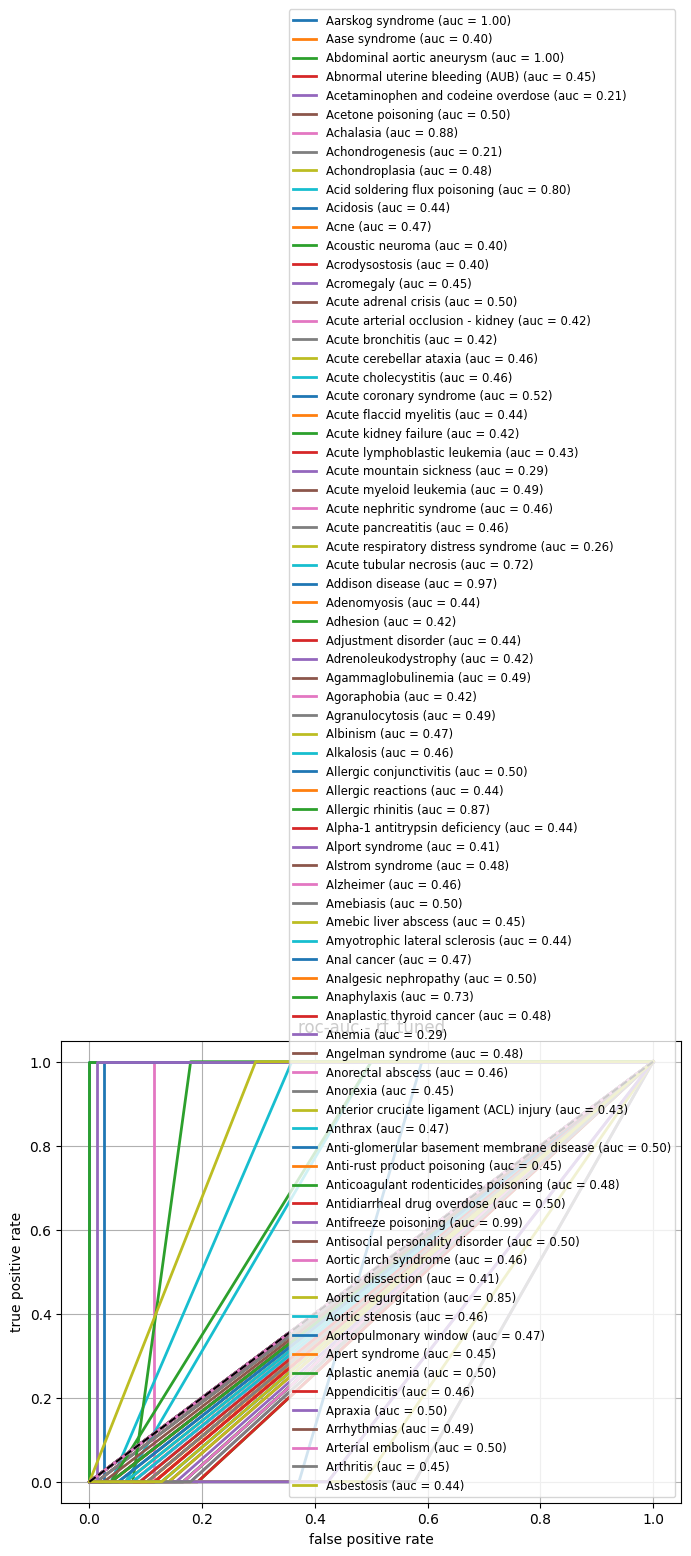

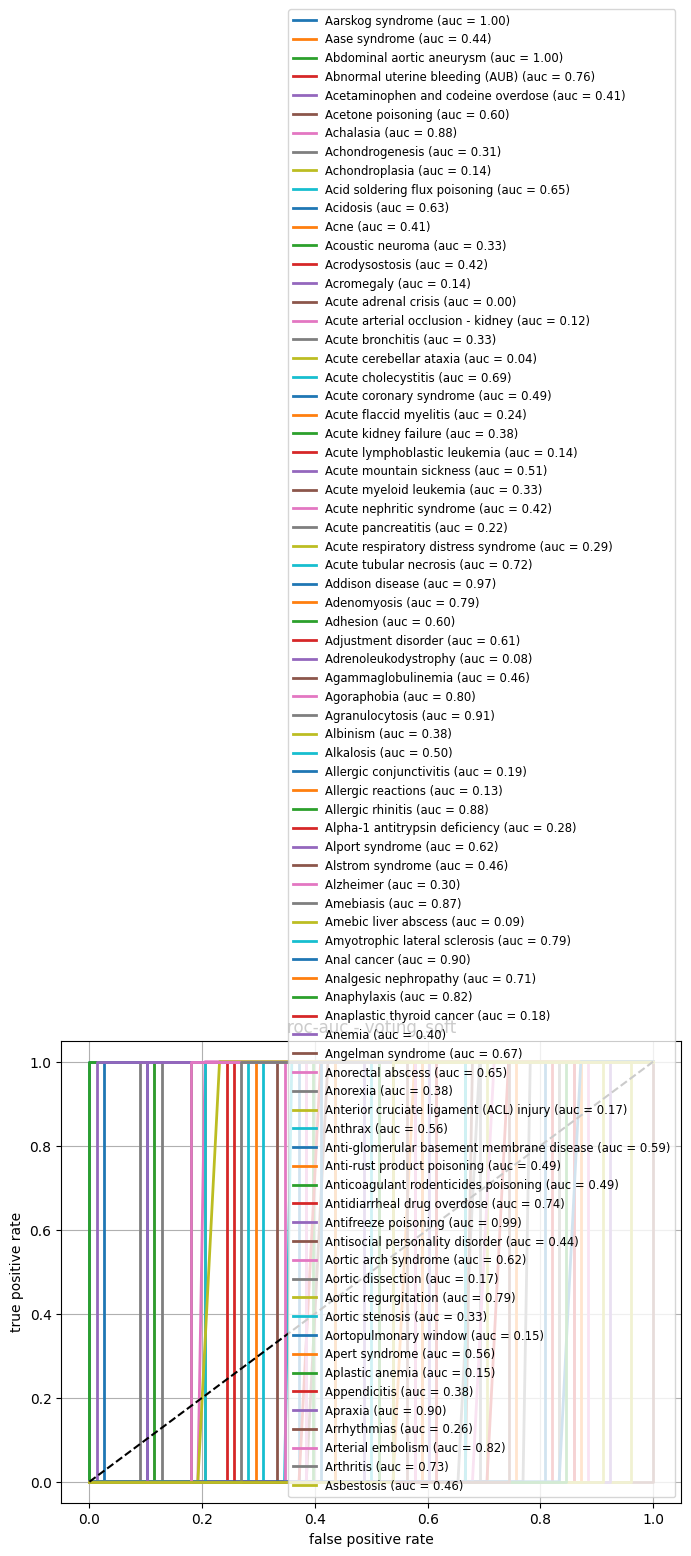

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# 1️⃣1️⃣ roc–auc (multiclass) for rf, voting, stacking
from sklearn.preprocessing import label_binarize
def plot_multiclass_roc_model(model, X_test, y_test, title=None):
    classes = np.unique(y_test)
    n_classes = len(classes)
    y_test_b = label_binarize(y_test, classes=classes)
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_b[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{le.classes_[i]} (auc = {roc_auc:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title(title or f'multiclass roc (one-vs-rest) - {type(model).__name__}')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.show()

for name, m in {'rf_tuned': rf_tuned, 'voting_soft': voting_soft, 'stacking': stack}.items():
    plot_multiclass_roc_model(m, X_test, y_test, title=f'roc-auc - {name}')

In [ ]:
# 1️⃣2️⃣ shap explainability (optional if shap/xgb not available)
if HAS_SHAP and HAS_XGB and xgb is not None:
    print('computing shap treeexplainer for xgboost...')
    explainer_xgb = shap.TreeExplainer(xgb)
    sample = X_test.sample(n=min(200, X_test.shape[0]), random_state=RANDOM_STATE)
    shap_values_xgb = explainer_xgb.shap_values(sample)
    try:
        shap.summary_plot(shap_values_xgb, sample, plot_type='bar')
        shap.summary_plot(shap_values_xgb, sample)
    except Exception as e:
        print('could not render shap plots:', e)
else:
    print('shap/xgb not available; skipping treeexplainer')

In [ ]:
# 1️⃣3️⃣ disease prediction function
def predict_disease(model, symptoms_list):
    row = [1.0 if col in symptoms_list else 0.0 for col in X_proc.columns]
    X_row = pd.DataFrame([row], columns=X_proc.columns)
    pred = model.predict(X_row)[0]
    return le.inverse_transform([pred])[0]

# 1️⃣4️⃣ top-k predictions
def predict_topk(model, symptoms_list, top_k=TOP_K):
    row = [1.0 if col in symptoms_list else 0.0 for col in X_proc.columns]
    X_row = pd.DataFrame([row], columns=X_proc.columns)
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(X_row)[0]
    else:
        probs = stack.predict_proba(X_row)[0]
    top_idx = np.argsort(probs)[::-1][:top_k]
    return [(le.classes_[i], float(probs[i])) for i in top_idx]

In [ ]:
# 1️⃣5️⃣ recommendation system
def get_description(disease_name):
    if description_df.empty:
        return 'description not available (file missing)'
    cols = [c.lower() for c in description_df.columns]
    if 'disease' in cols and 'description' in cols:
        row = description_df[description_df.iloc[:, cols.index('disease')] == disease_name]
        if not row.empty:
            return row.iloc[0, cols.index('description')]
    for _, r in description_df.iterrows():
        if disease_name in r.astype(str).values:
            for val in r.astype(str).values:
                if val and val.lower() != 'nan' and disease_name.lower() not in val.lower():
                    return val
    return 'description not available for this disease'

def get_list_from_df(df, disease_name):
    if df.empty:
        return []
    cols = [c.lower() for c in df.columns]
    if 'disease' in cols:
        idx = cols.index('disease')
        row = df[df.iloc[:, idx] == disease_name]
        if not row.empty:
            vals = row.iloc[0].drop(row.columns[idx]).dropna().astype(str).tolist()
            return vals
    for _, r in df.iterrows():
        if disease_name in r.astype(str).values:
            vals = [v for v in r.astype(str).values if v and v.lower() != 'nan' and disease_name.lower() not in v.lower()]
            return vals
    return []

def full_recommendation(disease_name):
    return {
        'disease': disease_name,
        'description': get_description(disease_name),
        'precautions': get_list_from_df(precautions_df, disease_name),
        'workouts': get_list_from_df(workout_df, disease_name),
        'medications': get_list_from_df(medications_df, disease_name),
        'diets': get_list_from_df(diets_df, disease_name)
    }

In [ ]:
# load recommendation CSVs (safe)
import pandas as pd
import os

def _safe_read_csv(path):
    try:
        if os.path.exists(path):
            return pd.read_csv(path)
    except Exception:
        try:
            return pd.read_csv(path, encoding='latin1')
        except Exception:
            pass
    return pd.DataFrame()

description_df = _safe_read_csv('description.csv')
precautions_df = _safe_read_csv('precautions_df.csv')
workout_df = _safe_read_csv('workout_df.csv')
medications_df = _safe_read_csv('medications.csv')
diets_df = _safe_read_csv('diets.csv')
print('recommendation CSVs loaded:', {
    'description': not description_df.empty,
    'precautions': not precautions_df.empty,
    'workout': not workout_df.empty,
    'medications': not medications_df.empty,
    'diets': not diets_df.empty,
})


recommendation CSVs loaded: {'description': True, 'precautions': True, 'workout': True, 'medications': True, 'diets': True}


In [ ]:
# 1️⃣6️⃣ end-to-end demo
# derive symptoms from a real test row and run full pipeline
row = X_test.iloc[[0]] if 'X_test' in globals() and hasattr(X_test, 'iloc') and len(X_test) > 0 else X.iloc[[0]]
true_label = y_test[0] if 'y_test' in globals() and hasattr(y_test, 'shape') and y_test.shape[0] > 0 else y.iloc[0]

symptoms_from_row = [c for c, v in zip(X_proc.columns, row.iloc[0].values) if v > 0]
print('symptoms from row (first 10):', symptoms_from_row[:10])
res = predict_topk_and_recommend(symptoms_from_row, top_k=5)
print('true label:', true_label)
print('predicted:', res['predicted'])
print('top-5:', res['topk'])
print('recommendation:', res['recommendation'])

# optional: SHAP for xgb if available
if 'xgb' in globals() and HAS_SHAP:
    try:
        explainer = shap.TreeExplainer(xgb)
        shap_values = explainer.shap_values(row)
        shap.summary_plot(shap_values, row, plot_type='bar')
    except Exception as e:
        print('shap plotting skipped:', e)


symptoms from row (first 10): ['Pain in the abdomen', 'Nausea and vomiting', 'Shock', 'Kidney failure', 'Difficulty breathing', 'Loss of vision', 'Severe pain in the throat', 'Severe pain or burning in the nose, eyes, ears, lips, or tongue', 'Decreased urine output', 'Blood in the stool']
true label: 9
predicted: Aase syndrome
top-5: [('Aase syndrome', 0.08), ('Acute flaccid myelitis', 0.08), ('Diphtheria', 0.075), ('Autonomic dysreflexia', 0.07), ('Alpha-1 antitrypsin deficiency', 0.065)]
recommendation: {'disease': 'Aase syndrome', 'description': 'description not available for this disease', 'precautions': [], 'workouts': [], 'medications': [], 'diets': []}
shap plotting skipped: need to call fit or load_model beforehand


In [ ]:
# 1️⃣7️⃣ save artifacts
import os, json, joblib

ARTIFACTS_DIR = 'artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

artifacts = {}
try:
    if 'rf' in globals():
        joblib.dump(rf, os.path.join(ARTIFACTS_DIR, 'model_rf_baseline.pkl'))
        artifacts['model_rf_baseline'] = 'model_rf_baseline.pkl'
except Exception as e:
    print('baseline rf save skipped:', e)

try:
    if 'model_rf_tuned' in globals():
        joblib.dump(model_rf_tuned, os.path.join(ARTIFACTS_DIR, 'model_rf_tuned.pkl'))
        artifacts['model_rf_tuned'] = 'model_rf_tuned.pkl'
except Exception as e:
    print('tuned rf save skipped:', e)

try:
    if 'voting_clf_soft' in globals():
        joblib.dump(voting_clf_soft, os.path.join(ARTIFACTS_DIR, 'voting_clf_soft.pkl'))
        artifacts['voting_clf_soft'] = 'voting_clf_soft.pkl'
    if 'voting_clf_hard' in globals():
        joblib.dump(voting_clf_hard, os.path.join(ARTIFACTS_DIR, 'voting_clf_hard.pkl'))
        artifacts['voting_clf_hard'] = 'voting_clf_hard.pkl'
    if 'voting' in globals():
        joblib.dump(voting, os.path.join(ARTIFACTS_DIR, 'voting.pkl'))
        artifacts['voting'] = 'voting.pkl'
except Exception as e:
    print('voting save skipped:', e)

try:
    if 'stack' in globals():
        joblib.dump(stack, os.path.join(ARTIFACTS_DIR, 'stacking_clf.pkl'))
        artifacts['stacking_clf'] = 'stacking_clf.pkl'
except Exception as e:
    print('stacking save skipped:', e)

try:
    joblib.dump(label_encoder_y, os.path.join(ARTIFACTS_DIR, 'label_encoder_y.pkl'))
    artifacts['label_encoder_y'] = 'label_encoder_y.pkl'
except Exception as e:
    print('label encoder save skipped:', e)

try:
    feature_cols = list(X_proc.columns)
    with open(os.path.join(ARTIFACTS_DIR, 'feature_cols.json'), 'w') as f:
        json.dump(feature_cols, f)
    artifacts['feature_cols'] = 'feature_cols.json'
except Exception as e:
    print('feature cols save skipped:', e)

try:
    with open(os.path.join(ARTIFACTS_DIR, 'artifacts_manifest.json'), 'w') as f:
        json.dump(artifacts, f, indent=2)
    print('saved artifacts:', artifacts)
except Exception as e:
    print('artifacts manifest save skipped:', e)


saved artifacts: {'model_rf_baseline': 'model_rf_baseline.pkl', 'voting': 'voting.pkl', 'stacking_clf': 'stacking_clf.pkl', 'label_encoder_y': 'label_encoder_y.pkl', 'feature_cols': 'feature_cols.json'}


In [ ]:
# ==== A. binary presence encoding (prototype matrix) ====
import pandas as pd, numpy as np
SYMPTOM_COLS = [c for c in df.columns if c != 'Prognosis']
# presence: 1 if non-empty/non-null string, else 0
presence_matrix = (df[SYMPTOM_COLS].astype(str).apply(lambda col: col.str.strip().str.lower())
                   .replace({'nan':'', 'none':'', '': ''})
                   .apply(lambda col: (col != '').astype(int)))
print('presence_matrix shape:', presence_matrix.shape)
print('avg symptoms per disease:', presence_matrix.sum(axis=1).mean())
# store prototypes
prototype_labels = df['Prognosis'].tolist()


presence_matrix shape: (391, 1326)
avg symptoms per disease: 1326.0


In [ ]:
# ==== B. cosine similarity retrieval functions ====
from sklearn.metrics.pairwise import cosine_similarity

# precompute normalized prototype matrix
proto_array = presence_matrix.values.astype(float)
# avoid divide by zero
row_norms = np.linalg.norm(proto_array, axis=1)
row_norms[row_norms == 0] = 1.0
proto_norm = proto_array / row_norms[:, None]

symptom_index = {c: i for i, c in enumerate(SYMPTOM_COLS)}

def build_input_vector(symptoms):
    vec = np.zeros(len(SYMPTOM_COLS), dtype=float)
    if isinstance(symptoms, dict):
        for name, val in symptoms.items():
            idx = symptom_index.get(name)
            if idx is not None and val:
                vec[idx] = 1.0
    elif isinstance(symptoms, list):
        for name in symptoms:
            idx = symptom_index.get(name)
            if idx is not None:
                vec[idx] = 1.0
    else:
        raise ValueError('symptoms must be list or dict')
    # normalize
    n = np.linalg.norm(vec)
    if n > 0: vec = vec / n
    return vec.reshape(1, -1)

def retrieve_topk_similarity(symptoms, k=5):
    q = build_input_vector(symptoms)
    sims = (proto_norm @ q.T).ravel()  # cosine similarity since rows are normalized
    top_idx = np.argsort(sims)[::-1][:k]
    results = [(prototype_labels[i], float(sims[i])) for i in top_idx]
    return results

print('similarity retrieval ready')


similarity retrieval ready


In [ ]:
# ==== C. masked symptom evaluation (hit@k) ====
import random
random.seed(RANDOM_STATE)

def evaluate_similarity(mask_frac=0.5, ks=(1,3,5,10)):
    hits = {k: 0 for k in ks}
    total = len(prototype_labels)
    for i, label in enumerate(prototype_labels):
        # symptoms present for disease i
        symptom_presence = presence_matrix.iloc[i]
        active = [SYMPTOM_COLS[j] for j, v in enumerate(symptom_presence.values) if v == 1]
        if not active:
            continue  # cannot evaluate if no symptoms
        # mask subset
        keep_n = max(1, int(len(active)*mask_frac))
        sampled = random.sample(active, keep_n)
        topk = retrieve_topk_similarity(sampled, k=max(ks))
        predicted_labels = [t[0] for t in topk]
        for k in ks:
            if label in predicted_labels[:k]:
                hits[k] += 1
    metrics = {f'hit@{k}': hits[k]/total for k in ks}
    return metrics

metrics = evaluate_similarity()
print('similarity evaluation metrics:', metrics)


similarity evaluation metrics: {'hit@1': 0.0025575447570332483, 'hit@3': 0.0076726342710997444, 'hit@5': 0.01278772378516624, 'hit@10': 0.02557544757033248}


In [ ]:
# ==== D. unified similarity-based prediction + recommendation ====

def predict_with_similarity(symptoms, top_k=5):
    topk = retrieve_topk_similarity(symptoms, k=top_k)
    best_label = topk[0][0] if topk else None
    reco = full_recommendation(best_label) if best_label else {}
    return {'topk': topk, 'predicted': best_label, 'recommendation': reco}

# demo
sample_symptoms_similarity = [SYMPTOM_COLS[i] for i in range(0, min(10, len(SYMPTOM_COLS)))]
print('demo symptoms (first 10 cols):', sample_symptoms_similarity)
print(predict_with_similarity(sample_symptoms_similarity, top_k=5))


demo symptoms (first 10 cols): ['Belly button that sticks out', 'Bulge in the groin or scrotum', 'Delayed sexual maturity', 'Delayed teeth', 'Downward palpebral slant to eyes\xa0', 'Hairline with a "widow\'s peak"', 'Mildly sunken chest (pectus excavatum)', 'Mild to moderate cognitive problems', 'Mild to moderate short height', 'Poorly developed middle section of the face']
{'topk': [('Amyotrophic lateral sclerosis', 0.08684168428648437), ('Cholangiocarcinoma', 0.08684168428648437), ('Bunions', 0.08684168428648437), ('Colorectal cancer', 0.08684168428648437), ('Acute mountain sickness', 0.08684168428648437)], 'predicted': 'Amyotrophic lateral sclerosis', 'recommendation': {'disease': 'Amyotrophic lateral sclerosis', 'description': 'description not available for this disease', 'precautions': [], 'workouts': [], 'medications': [], 'diets': []}}


In [ ]:
# ==== E. save similarity artifacts ====
import os, json, joblib
SIM_ART_DIR = 'artifacts'
os.makedirs(SIM_ART_DIR, exist_ok=True)
joblib.dump(presence_matrix, os.path.join(SIM_ART_DIR, 'presence_matrix.pkl'))
with open(os.path.join(SIM_ART_DIR, 'prototype_labels.json'), 'w') as f:
    json.dump(prototype_labels, f)
with open(os.path.join(SIM_ART_DIR, 'symptom_columns.json'), 'w') as f:
    json.dump(SYMPTOM_COLS, f)
print('saved similarity artifacts: presence_matrix.pkl, prototype_labels.json, symptom_columns.json')


saved similarity artifacts: presence_matrix.pkl, prototype_labels.json, symptom_columns.json
